In [1]:
import numpy as np
import matplotlib.pyplot as plt

Verification of derived values:
Z₀ = √(L/C) = 1.0000 Ω (should be 1.0)
β₀ = ω√(LC) = 25.1327 rad/m (should be 25.1327)


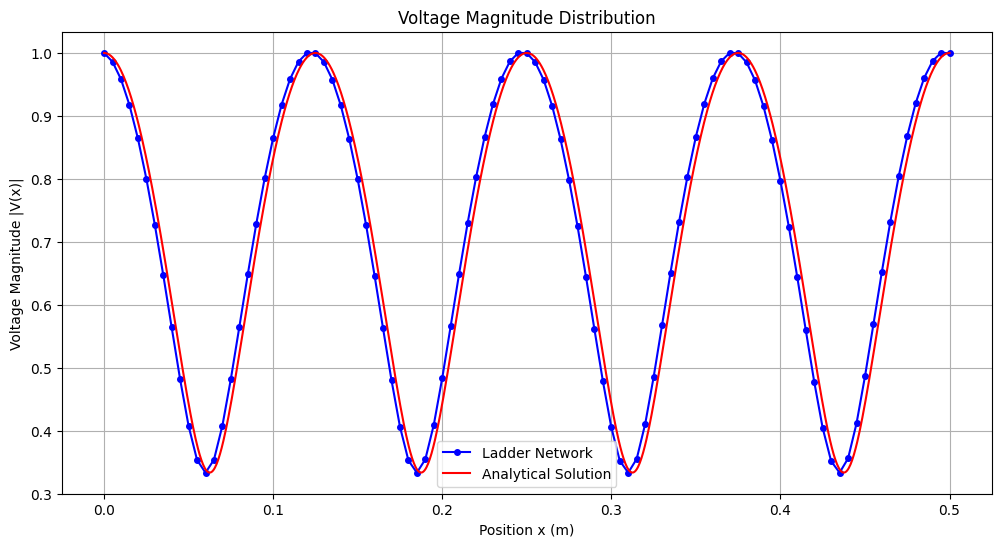

In [2]:
#------------------------------Question 1---------------------------------------

# Given parameters
Z0 = 1.0  # Characteristic impedance (Ohms)
ZL = 3 * Z0  # Load impedance (Ohms)
l0 = 0.5  # Length (m)
beta_l0 = 4 * np.pi # Transmission
N = 100  # Number of sections
Vs = 1.0  # Source voltage
omega = 1.0  # rad/s

# Calculate β₀
beta_0 = beta_l0 / l0  # = 8π rad/m

# Calculate per-unit-length parameters from β₀ = ω√(LC) and Z₀ = √(L/C)
C_per_unit = beta_0 / (omega * Z0)  # = 8π F/m
L_per_unit = beta_0 / omega  # = 8π H/m

# Verify
print("Verification of derived values:")
print(f"Z₀ = √(L/C) = {np.sqrt(L_per_unit/C_per_unit):.4f} Ω (should be 1.0)")
print(f"β₀ = ω√(LC) = {omega*np.sqrt(L_per_unit*C_per_unit):.4f} rad/m (should be {beta_0:.4f})")

# Calculate lumped elements
dx = l0 / N
L = L_per_unit * dx
C = C_per_unit * dx

# Initialize arrays
Z = np.zeros(N+1, dtype=complex)
V = np.zeros(N+1, dtype=complex)
I = np.zeros(N+1, dtype=complex)

# Set terminal condition
Z[-1] = ZL

# Backward recursion for impedances
for n in range(N-1, -1, -1):
    Z_L = 1j * omega * L
    Z_C = 1 / (1j * omega * C)
    Z[n] = 1 / (1/Z_C + 1/(Z[n+1] + Z_L))

# Forward wave propagation
V[0] = Vs
I[0] = V[0] / Z[0]

for n in range(N):
    I[n+1] = I[n] - 1j * omega * C * V[n]
    V[n+1] = V[n] - 1j * omega * L * I[n+1]

# Spatial coordinates
x_ladder = np.linspace(0, l0, N+1)
x_analytical = np.linspace(0, l0, 1000)

# Compute magnitudes
V_ladder_mag = np.abs(V)
V_analytical_mag = (2/3) * np.sqrt(5/4 + np.cos(8*np.pi*x_analytical/l0))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(x_ladder, V_ladder_mag, 'bo-', label='Ladder Network', markersize=4)
plt.plot(x_analytical, V_analytical_mag, 'r-', label='Analytical Solution')
plt.grid(True)
plt.xlabel('Position x (m)')
plt.ylabel('Voltage Magnitude |V(x)|')
plt.title('Voltage Magnitude Distribution')
plt.legend()
plt.show()

In [3]:
#------------------------------Question 2---------------------------------------
# Vs---L1---+---L2---+---L3---+
#           |        |        |
#           C1       C2       ZL
#           |        |        |
#          GND      GND      GND

We shall proceed with the definition of state variables in a similar fashion as in HW 11

State Variables:
- x₁ = i₁ (current through L1)
- x₂ = i₂ (current through L2)
- x₃ = i₃ (current through L3)
- x₄ = v₁ (voltage across C1)
- x₅ = v₂ (voltage across C2)

KCL and KVL equations:

1) KCL at nodes (capacitor currents):
$$\dot{x_4} = x_1 - x_2$$
$$\dot{x_5} = x_2 - x_3$$

2) KVL for inductors:
$$\dot{x_1} = cos(t) - x_4$$
$$\dot{x_2} = x_4 - x_5$$
$$\dot{x_3} = x_5 - x_3$$ (with ZL=1)

In matrix form:
$$\begin{bmatrix} \dot{x_1} \\ \dot{x_2} \\ \dot{x_3} \\ \dot{x_4} \\ \dot{x_5} \end{bmatrix} =
\begin{bmatrix}
0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1 & -1 \\
0 & 0 & -1 & 0 & 1 \\
1 & -1 & 0 & 0 & 0 \\
0 & 1 & -1 & 0 & 0
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \end{bmatrix} +
\begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}cos(t)$$

**Note**

For n steps beyond three, each additional step adds a new inductor current state variable iₙ with equation ẋₙ = vₙ₋₁ - vₙ, and a new capacitor voltage state variable vₙ₋₁ with equation v̇ₙ₋₁ = iₙ₋₁ - iₙ. The final inductor equation always takes the form ẋₙ = vₙ₋₁ - ZLxₙ where xₙ is the current through the last inductor. The input remains at the first inductor with ẋ₁ = cos(t) - v₁, while all middle inductor and capacitor equations follow the same pattern of differences between adjacent nodes.

In [4]:
from scipy.integrate import solve_ivp

# Generic formulaes to solve n step ladders (ss, and transient soln)
def build_ladder_matrices(n_steps, ZL, V0=1.0):
    """Build A and B matrices for n-step ladder network."""
    n = 2*n_steps - 1
    A = np.zeros((n, n))
    B = np.zeros(n)

    # First inductor
    A[0, n_steps] = -1
    B[0] = V0

    # Middle inductors
    for i in range(1, n_steps-1):
        A[i, n_steps+i-1] = 1
        A[i, n_steps+i] = -1

    # Last inductor
    A[n_steps-1, 2*n_steps-2] = 1
    A[n_steps-1, n_steps-1] = -ZL

    # Capacitors
    for i in range(n_steps-1):
        A[n_steps+i, i] = 1
        A[n_steps+i, i+1] = -1

    return A, B

def system_nstep(t, X, A, B):
    """System of ODEs for n-step ladder"""
    return A @ X + B * np.cos(t)

def get_steady_state(A, B, omega=1.0):
    """Get steady-state phasor solution"""
    n = len(A)
    I = np.eye(n)
    jwI_minus_A = 1j * omega * I - A
    X_phasors = np.linalg.solve(jwI_minus_A, B)
    return X_phasors

def phasor_to_time(X_phasors, t, omega=1.0):
    """Convert phasors to time domain"""
    return np.real(X_phasors.reshape(-1, 1) * np.exp(1j * omega * t))

def solve_ladder_network(n_steps, ZL, V0=1.0, t_span=(0, 50), n_points=1000):
    """Solve n-step ladder network for both transient and steady state"""
    # Build system matrices
    A, B = build_ladder_matrices(n_steps, ZL, V0)

    # Time points
    t_eval = np.linspace(*t_span, n_points)

    # Initial conditions
    X0 = np.zeros(len(A))

    # Solve transient
    sol = solve_ivp(system_nstep, t_span, X0, args=(A, B),
                    t_eval=t_eval, method='RK45')

    # Get steady state
    X_phasors = get_steady_state(A, B)
    X_steady = phasor_to_time(X_phasors, sol.t)

    # Create labels
    labels = []
    for i in range(n_steps):
        labels.append(f'i_{i+1}(t)')
    for i in range(n_steps-1):
        labels.append(f'v_{i+1}(t)')

    return sol.t, sol.y, X_steady, labels

def plot_solutions(t, X_transient, X_steady, labels):
    """Plot all transient and steady-state solutions"""
    n = len(labels)

    # Create color maps for currents and voltages
    current_colors = plt.cm.Blues(np.linspace(0.5, 0.9, n//2 + 1))
    voltage_colors = plt.cm.Reds(np.linspace(0.5, 0.9, n//2))

    plt.figure(figsize=(12, 6))

    # Plot currents
    for i in range(n//2 + 1):
        plt.plot(t, X_transient[i], color=current_colors[i],
                label=f'{labels[i]} (trans)', alpha=0.7)
        plt.plot(t, X_steady[i], '--', color=current_colors[i],
                label=f'{labels[i]} (steady)', alpha=0.7)

    # Plot voltages
    for i in range(n//2 + 1, n):
        plt.plot(t, X_transient[i], color=voltage_colors[i-n//2-1],
                label=f'{labels[i]} (trans)', alpha=0.7)
        plt.plot(t, X_steady[i], '--', color=voltage_colors[i-n//2-1],
                label=f'{labels[i]} (steady)', alpha=0.7)

    plt.xlabel('Time (s)')
    plt.ylabel('Current (A) / Voltage (V)')
    plt.title('Ladder Network Response')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    return plt.gcf(), plt.gca()

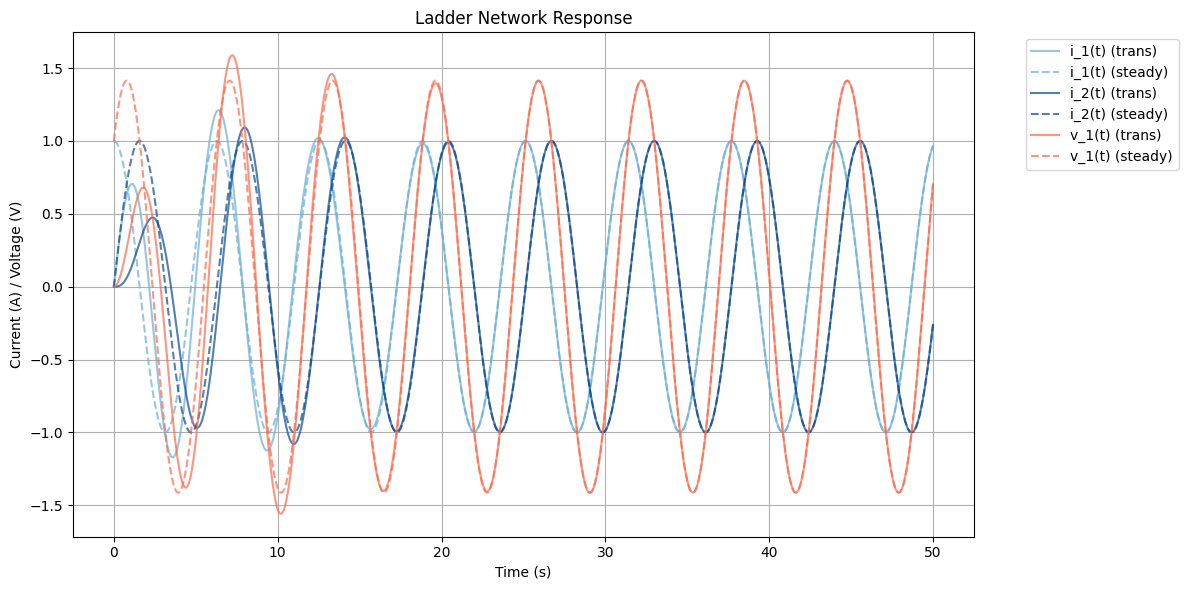


Steady State Solutions (Phasor Form):
i_1(t): 1.0000∠0.0°
i_2(t): 1.0000∠-90.0°
v_1(t): 1.4142∠-45.0°


In [5]:
# 2 steps (in hw11)
n_steps = 2
ZL = 1.0
V0 = 1.0

# Solve the network
t, X_transient, X_steady, labels = solve_ladder_network(n_steps, ZL, V0)

# Plot results
fig, axs = plot_solutions(t, X_transient, X_steady, labels)
plt.show()

# Print steady state information
X_phasors = get_steady_state(*build_ladder_matrices(n_steps, ZL, V0))
print("\nSteady State Solutions (Phasor Form):")
for i, label in enumerate(labels):
    mag = np.abs(X_phasors[i])
    phase = np.angle(X_phasors[i], deg=True)
    print(f"{label}: {mag:.4f}∠{phase:.1f}°")

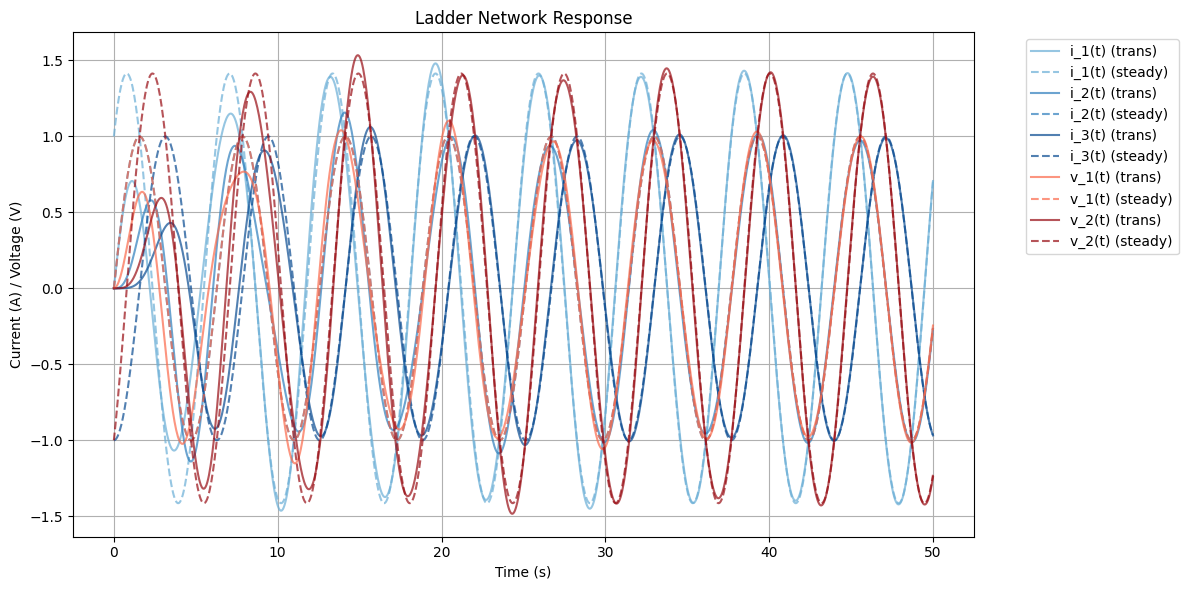


Steady State Solutions (Phasor Form):
i_1(t): 1.4142∠-45.0°
i_2(t): 1.0000∠-90.0°
i_3(t): 1.0000∠180.0°
v_1(t): 1.0000∠-90.0°
v_2(t): 1.4142∠-135.0°


In [6]:
# 3 steps
n_steps = 3
ZL = 1.0
V0 = 1.0

# Solve the network
t, X_transient, X_steady, labels = solve_ladder_network(n_steps, ZL, V0)

# Plot results
fig, axs = plot_solutions(t, X_transient, X_steady, labels)
plt.show()

# Print steady state information
X_phasors = get_steady_state(*build_ladder_matrices(n_steps, ZL, V0))
print("\nSteady State Solutions (Phasor Form):")
for i, label in enumerate(labels):
    mag = np.abs(X_phasors[i])
    phase = np.angle(X_phasors[i], deg=True)
    print(f"{label}: {mag:.4f}∠{phase:.1f}°")

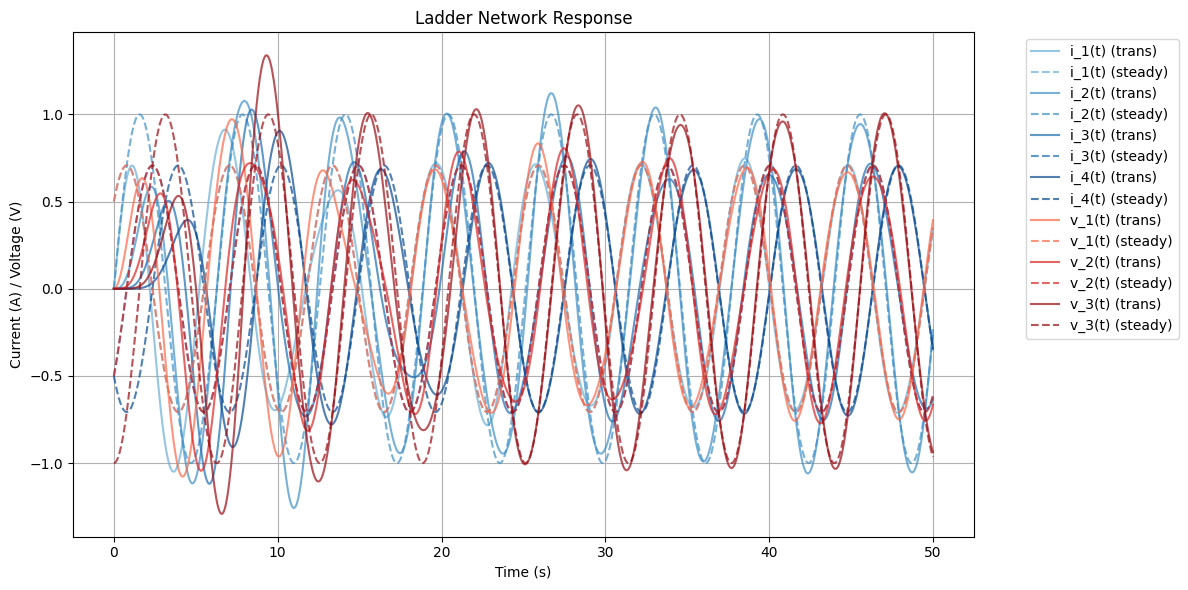


Steady State Solutions (Phasor Form):
i_1(t): 0.7071∠-45.0°
i_2(t): 1.0000∠-90.0°
i_3(t): 0.7071∠-135.0°
i_4(t): 0.7071∠135.0°
v_1(t): 0.7071∠-45.0°
v_2(t): 0.7071∠-135.0°
v_3(t): 1.0000∠-180.0°


In [8]:
# 4 steps
n_steps = 4
ZL = 1.0
V0 = 1.0

# Solve the network
t, X_transient, X_steady, labels = solve_ladder_network(n_steps, ZL, V0)

# Plot results
fig, axs = plot_solutions(t, X_transient, X_steady, labels)
plt.show()

# Print steady state information
X_phasors = get_steady_state(*build_ladder_matrices(n_steps, ZL, V0))
print("\nSteady State Solutions (Phasor Form):")
for i, label in enumerate(labels):
    mag = np.abs(X_phasors[i])
    phase = np.angle(X_phasors[i], deg=True)
    print(f"{label}: {mag:.4f}∠{phase:.1f}°")

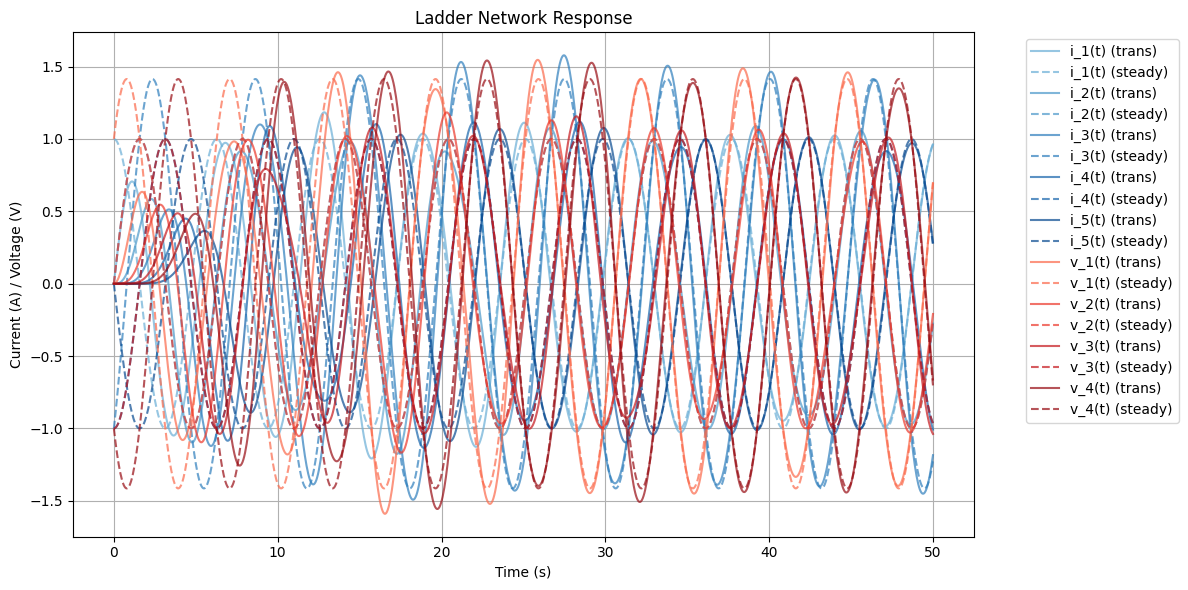


Steady State Solutions (Phasor Form):
i_1(t): 1.0000∠0.0°
i_2(t): 1.0000∠-90.0°
i_3(t): 1.4142∠-135.0°
i_4(t): 1.0000∠-180.0°
i_5(t): 1.0000∠90.0°
v_1(t): 1.4142∠-45.0°
v_2(t): 1.0000∠-90.0°
v_3(t): 1.0000∠-180.0°
v_4(t): 1.4142∠135.0°


In [9]:
# 5 steps
n_steps = 5
ZL = 1.0
V0 = 1.0

# Solve the network
t, X_transient, X_steady, labels = solve_ladder_network(n_steps, ZL, V0)

# Plot results
fig, axs = plot_solutions(t, X_transient, X_steady, labels)
plt.show()

# Print steady state information
X_phasors = get_steady_state(*build_ladder_matrices(n_steps, ZL, V0))
print("\nSteady State Solutions (Phasor Form):")
for i, label in enumerate(labels):
    mag = np.abs(X_phasors[i])
    phase = np.angle(X_phasors[i], deg=True)
    print(f"{label}: {mag:.4f}∠{phase:.1f}°")

## **Comment**
The transient states of the system converges to the steady-state solutions